In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import autograd
import torch.nn.functional as F
import time

images = np.load("D:/work/JHUschoolStuff/machinelearning/project1/cs475_project_data/images.npy")
labels = np.load("D:/work/JHUschoolStuff/machinelearning/project1/cs475_project_data/labels.npy")
test = np.load("D:/work/JHUschoolStuff/machinelearning/project1/cs475_project_data/test_images.npy")
height = images.shape[1]
width = images.shape[2]
size = height * width
images = (images - images.mean()) / images.std()
data = images.reshape(images.shape[0],size)
data = torch.from_numpy(data).float()
labels = torch.from_numpy(labels).float()
test_data = test.reshape(test.shape[0], size)
test_data = (test_data - test_data.mean()) / test_data.std()
train_seqs = data[0:45000,:]
train_labels = labels[0:45000]
val_seqs = data[45000:,:]
val_labels = labels[45000:]

In [3]:
class TwoLayerNN(torch.nn.Module):
    def __init__(self, layer_1):
        super().__init__()
        self.layer_1 = torch.nn.Linear(height * width, layer_1)
        self.layer_2 = torch.nn.Linear(layer_1, 5)
        self.drop = torch.nn.Dropout(p = 0.3)
    def forward(self, x):
        x = self.layer_1(x)
        y = F.relu(x)
        y = self.drop(y)
        z = self.layer_2(y)
        return z

In [14]:
class ThreeLayerNN(torch.nn.Module):
    def __init__(self, layer_1, layer_2):
        super().__init__()
        self.layer_1 = torch.nn.Linear(height * width, layer_1)
        self.layer_2 = torch.nn.Linear(layer_1, layer_2)
        self.layer_3 = torch.nn.Linear(layer_2, 5)
    def forward(self, x):
        x = self.layer_1(x)
        y = F.relu(x)
        z = self.layer_2(y)
        a = F.relu(z)
        b = self.layer_3(a)
        return b

In [15]:
class FourLayerNN(torch.nn.Module):
    def __init__(self, layer_1, layer_2, layer_3):
        super().__init__()
        self.layer_1 = torch.nn.Linear(height * width, layer_1)
        self.layer_2 = torch.nn.Linear(layer_1, layer_2)
        self.layer_3 = torch.nn.Linear(layer_2, layer_3)
        self.layer_4 = torch.nn.Linear(layer_3, 5)
    def forward(self, x):
        x = self.layer_1(x)
        y = F.relu(x)
        z = self.layer_2(y)
        a = F.relu(z)
        b = self.layer_3(a)
        c = F.relu(b)
        d = self.layer_4(c)
        return d

In [4]:
def train(model, optimizer, batch_size):
    # model.train() puts our model in train mode, which can require different
    # behavior than eval mode (for example in the case of dropout).
    model.train()
    
    # i is is a 1-D array with shape [batch_size]
    i = np.random.choice(train_seqs.shape[0], size=batch_size, replace=False)
    i = torch.from_numpy(i).long()
    x = autograd.Variable(train_seqs[i, :])
    y = autograd.Variable(train_labels[i]).long()
    optimizer.zero_grad()
    y_hat_ = model(x)
    loss = F.multi_margin_loss(y_hat_, y) #using multi_margin_loss for last one
    #loss = F.cross_entropy(y_hat_, y)
    loss.backward()
    optimizer.step()
    return loss.data[0]


In [5]:
def approx_train_accuracy(model):
    model.eval()
    i = np.random.choice(train_seqs.shape[0], size=1000, replace=False)
    i = torch.from_numpy(i).long()
    x = autograd.Variable(train_seqs[i, :])
    y = autograd.Variable(train_labels[i]).long()
    y_hat_ = model(x)
    y_hat = np.zeros(1000)
    for i in range(1000):
        y_hat[i] = torch.max(y_hat_[i,:].data, 0)[1][0]
    return accuracy(y_hat, y.data.numpy())

In [6]:
def val_accuracy(model):
    model.eval()
    x = autograd.Variable(val_seqs)
    y = autograd.Variable(val_labels)
    y_hat_ = model(x)
    y_hat = np.zeros(5000)
    for i in range(5000):
        y_hat[i] = torch.max(y_hat_[i,:].data, 0)[1][0]
    return accuracy(y_hat, y.data.numpy())

In [7]:
def accuracy(y, y_hat):
    return (y == y_hat).astype(np.float).mean()

In [8]:
def plot(train_accs, val_accs):
    plt.figure(200)
    plt.title('Training Accuracy')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.plot(train_accs, 'b')
    plt.show()
    plt.figure(300)
    plt.title('Validation Accuracy')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')   
    plt.plot(val_accs, 'b')
    plt.show()

In [9]:
def runModel(model, batch_size, NUM_OPT_STEPS, optimizer):
    train_accs, val_accs = [], []
    for i in range(NUM_OPT_STEPS):
        train(model, optimizer, batch_size)
        if i % 100 == 0:
            train_accs.append(approx_train_accuracy(model))
            val_accs.append(val_accuracy(model))
            print("%6d %5.2f %5.2f" % (i, train_accs[-1], val_accs[-1]))
    plot(train_accs, val_accs)

     0  0.37  0.36
   100  0.78  0.79
   200  0.78  0.79
   300  0.80  0.80
   400  0.80  0.81
   500  0.85  0.83
   600  0.83  0.83
   700  0.84  0.83
   800  0.86  0.85
   900  0.87  0.84
  1000  0.87  0.84
  1100  0.86  0.85
  1200  0.87  0.85
  1300  0.88  0.86
  1400  0.85  0.86
  1500  0.88  0.86
  1600  0.89  0.86
  1700  0.88  0.86
  1800  0.88  0.86
  1900  0.87  0.86
  2000  0.89  0.86
  2100  0.87  0.86
  2200  0.87  0.86
  2300  0.89  0.86
  2400  0.89  0.87
  2500  0.90  0.86
  2600  0.91  0.87
  2700  0.89  0.86
  2800  0.91  0.87
  2900  0.91  0.87
  3000  0.91  0.87
  3100  0.90  0.87
  3200  0.91  0.87
  3300  0.91  0.87
  3400  0.89  0.87
  3500  0.93  0.87
  3600  0.92  0.88
  3700  0.92  0.87
  3800  0.91  0.87
  3900  0.92  0.87
  4000  0.91  0.87
  4100  0.90  0.87
  4200  0.93  0.88
  4300  0.90  0.87
  4400  0.92  0.87
  4500  0.92  0.87
  4600  0.91  0.88
  4700  0.93  0.88
  4800  0.92  0.87
  4900  0.92  0.86
  5000  0.92  0.87
  5100  0.93  0.87
  5200  0.94

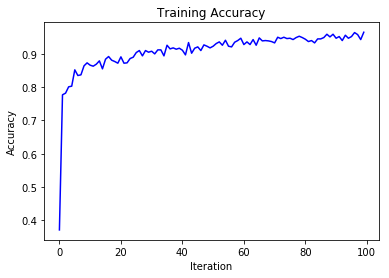

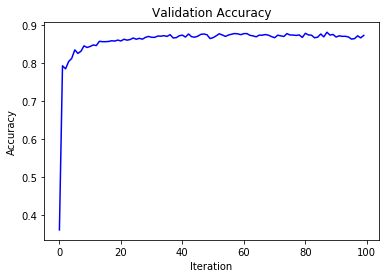

In [22]:
three_layer = ThreeLayerNN(200, 100)
optimizer_three_layer = torch.optim.Adam(three_layer.parameters(), lr=0.001)
runModel(three_layer, 32, 10000, optimizer_three_layer)

     0  0.29  0.28
   100  0.78  0.76
   200  0.77  0.79
   300  0.80  0.81
   400  0.85  0.82
   500  0.83  0.82
   600  0.82  0.82
   700  0.84  0.84
   800  0.82  0.83
   900  0.83  0.83
  1000  0.85  0.84
  1100  0.84  0.85
  1200  0.85  0.85
  1300  0.88  0.85
  1400  0.88  0.86
  1500  0.87  0.85
  1600  0.86  0.85
  1700  0.87  0.86
  1800  0.89  0.86
  1900  0.85  0.85
  2000  0.89  0.86
  2100  0.88  0.86
  2200  0.87  0.86
  2300  0.87  0.86
  2400  0.89  0.86
  2500  0.89  0.86
  2600  0.88  0.86
  2700  0.89  0.86
  2800  0.88  0.86
  2900  0.91  0.87
  3000  0.89  0.87
  3100  0.89  0.86
  3200  0.90  0.87
  3300  0.91  0.87
  3400  0.92  0.87
  3500  0.92  0.87
  3600  0.90  0.87
  3700  0.90  0.88
  3800  0.90  0.87
  3900  0.94  0.87
  4000  0.90  0.87
  4100  0.89  0.87
  4200  0.90  0.88
  4300  0.90  0.87
  4400  0.92  0.87
  4500  0.90  0.87
  4600  0.93  0.87
  4700  0.89  0.87
  4800  0.92  0.88
  4900  0.92  0.87
  5000  0.92  0.88
  5100  0.92  0.87
  5200  0.91

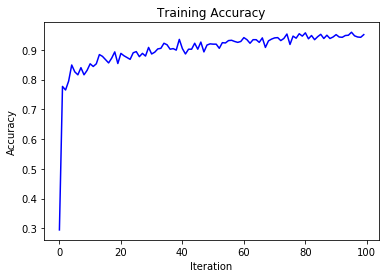

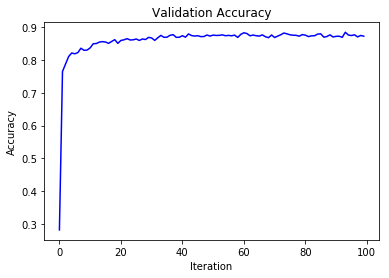

In [23]:
four_layer = FourLayerNN(200, 100, 50)
optimizer_four_layer = torch.optim.Adam(four_layer.parameters(), lr=0.001)
runModel(four_layer, 32, 10000, optimizer_four_layer)

     0  0.29  0.30
   100  0.78  0.78
   200  0.78  0.79
   300  0.80  0.80
   400  0.80  0.81
   500  0.82  0.81
   600  0.80  0.82
   700  0.83  0.82
   800  0.83  0.82
   900  0.84  0.83
  1000  0.84  0.83
  1100  0.85  0.83
  1200  0.85  0.84
  1300  0.86  0.84
  1400  0.84  0.84
  1500  0.84  0.84
  1600  0.85  0.84
  1700  0.86  0.84
  1800  0.84  0.85
  1900  0.83  0.85
  2000  0.84  0.85
  2100  0.86  0.85
  2200  0.85  0.85
  2300  0.86  0.85
  2400  0.88  0.85
  2500  0.86  0.85
  2600  0.87  0.86
  2700  0.87  0.86
  2800  0.87  0.85
  2900  0.87  0.86
  3000  0.88  0.86
  3100  0.88  0.86
  3200  0.89  0.86
  3300  0.88  0.86
  3400  0.88  0.86
  3500  0.86  0.86
  3600  0.88  0.86
  3700  0.88  0.86
  3800  0.87  0.86
  3900  0.88  0.87
  4000  0.87  0.86
  4100  0.87  0.86
  4200  0.91  0.86
  4300  0.87  0.86
  4400  0.90  0.86
  4500  0.89  0.86
  4600  0.90  0.86
  4700  0.89  0.86
  4800  0.89  0.86
  4900  0.88  0.86
  5000  0.91  0.87
  5100  0.88  0.87
  5200  0.88

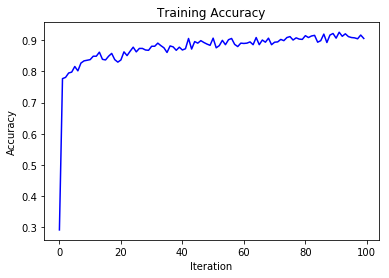

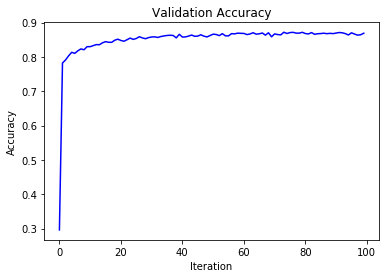

In [24]:
two_layer = TwoLayerNN(100) #using dropout at 0.3
optimizer_two_layer = torch.optim.Adam(two_layer.parameters(), lr=0.001)
runModel(two_layer, 32, 10000, optimizer_two_layer)

     0  0.44  0.43
   100  0.78  0.79
   200  0.81  0.81
   300  0.82  0.82
   400  0.84  0.83
   500  0.83  0.84
   600  0.85  0.85
   700  0.87  0.83
   800  0.86  0.85
   900  0.86  0.86
  1000  0.86  0.86
  1100  0.88  0.86
  1200  0.88  0.86
  1300  0.89  0.85
  1400  0.88  0.85
  1500  0.90  0.85
  1600  0.89  0.86
  1700  0.91  0.86
  1800  0.89  0.86
  1900  0.89  0.86
  2000  0.88  0.87
  2100  0.89  0.86
  2200  0.89  0.87
  2300  0.91  0.87
  2400  0.89  0.87
  2500  0.90  0.86
  2600  0.89  0.87
  2700  0.89  0.86
  2800  0.90  0.87
  2900  0.92  0.87
  3000  0.90  0.87
  3100  0.90  0.87
  3200  0.90  0.87
  3300  0.90  0.87
  3400  0.91  0.87
  3500  0.91  0.87
  3600  0.91  0.87
  3700  0.92  0.87
  3800  0.91  0.87
  3900  0.91  0.87
  4000  0.93  0.87
  4100  0.93  0.88
  4200  0.91  0.88
  4300  0.92  0.87
  4400  0.93  0.88
  4500  0.92  0.87
  4600  0.94  0.87
  4700  0.92  0.88
  4800  0.93  0.87
  4900  0.93  0.87
  5000  0.93  0.88
  5100  0.93  0.88
  5200  0.93

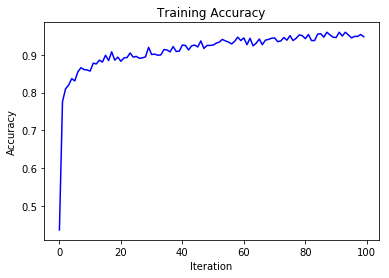

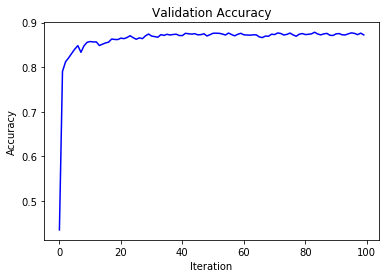

80.23156976699829


In [10]:
start = time.time()
two_layer = TwoLayerNN(200) #using dropout at 0.3
optimizer_two_layer = torch.optim.Adam(two_layer.parameters(), lr=0.001)
runModel(two_layer, 65, 10000, optimizer_two_layer)#using multi hinge loss
end = time.time()
print(end - start)

Best validation accuracy achieved was 88. This was using my two layer neural net with 200 units, learning rate of 0.001 using Adam optimizer, 10k optimization steps, and 65 batch size. This was also run with a dropout before the second layer with probability 0.3 and using multi hinge loss instead of cross entropy loss. The total time was about 76 seconds.